We need to make sure that we have sufficient read depth and correlations.

In [2]:
import pandas
import numpy
import scipy.stats
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import collections

In [3]:
from curation_common import *

In [4]:
from htsworkflow.submission.results import read_result_list

In [5]:
%matplotlib inline

In [6]:
root=os.path.expanduser('~/proj/submission/encode-y3q3')

In [7]:
def load_fpkms(experiment_files):
    """Load FPKMs out of RSEM results into a pandas dataframe
    
    Columns will be library accession identifiers.
    """
    TPM_COL = 5
    FPKM_COL = 6
    results = []
    libraries = []
    for i, row in enumerate(experiment_files):
        experiment = str(row['experiment'])
        library = str(row['library'])[-12:-1]
        url = str(row['file_href'])
        fpkms = pandas.read_csv(url, sep='\t', index_col=0, usecols=[0, FPKM_COL])
        libraries.append(library)
        results.append(fpkms)
    df = pandas.concat(results, axis=1)
    df.columns = libraries
    return df

In [8]:
mice = read_result_list(os.path.join(root, 'mice.txt'))

In [9]:
def load_summaries(result_map):
    samstats = []
    coverages = []
    fractions = []
    rsem_fpkms = []
    names = []
    
    for lib_id, name in result_map:
        names.append(name)
        result_dir = os.path.join(root, name)

        samstat_filename = os.path.join(result_dir, 'Aligned.sortedByCoord.out.samstats')
        samstat = pandas.read_csv(samstat_filename, sep=':\t', index_col=0, header=None, 
                                   names=['samstats', name])
        samstats.append(samstat)
    
        coverage_filename = os.path.join(result_dir, 'Aligned.sortedByCoord.out.coverage')
        coverage = pandas.read_csv(coverage_filename, sep='\t', index_col=0, header=None,
                                  names=['coverage', name])
        coverages.append(coverage)
    
        fraction_filename = os.path.join(result_dir, 'Aligned.sortedByCoord.out.read_fraction')
        fraction = pandas.read_csv(fraction_filename, sep=':\t', index_col=0, 
                                   header=None, skiprows=1, names=['Class', name])
        fractions.append(fraction)
    
        rsem_filename = os.path.join(result_dir, 'Aligned.toTranscriptome.out_rsem.genes.results')
        rsem_fpkm = pandas.read_csv(rsem_filename, sep='\t', header=0, index_col=0, usecols=[0, 6])
        rsem_fpkms.append(rsem_fpkm)
    
    rsem_df = pandas.concat(rsem_fpkms, axis=1)
    rsem_df.columns = names
    return {
        'samstats': pandas.concat(samstats, axis=1),
        'coverage': pandas.concat(coverages, axis=1),
        'fractions': pandas.concat(fractions, axis=1),
        'rsem_fpkms': rsem_df,
    }

In [10]:
summaries = load_summaries(mice)

/usr/lib/python3/dist-packages/pandas/io/parsers.py:639: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [11]:
with pandas.ExcelWriter('/tmp/y3q3.xlsx') as w:
    summaries['samstats'].to_excel(w, sheet_name='SAMstats', index_label=None)
    summaries['coverage'].to_excel(w, sheet_name='coverage', index=False)
    summaries['fractions'].to_excel(w, sheet_name='fractions', index_label=None)
    summaries['rsem_fpkms'].to_excel(w, sheet_name='rsem_fpkms')
w.close()

In [12]:
def replicate_scores(table, rep1_name, rep2_name, Acutoff=0):
    """Compute correlations, MAD, and SD replicate comparison scores
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    
    eitherzero = (rep1 == 0) | (rep2 == 0)
    replz1 = numpy.log2(rep1[eitherzero != True])
    replz2 = numpy.log2(rep2[eitherzero != True])
    
    M = replz1 - replz2
    A = (replz1 + replz2) / 2.0

    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(replz1[A > Acutoff]),
            
        'Naïve Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Naïve Spearman': scipy.stats.spearmanr(rep1, rep2)[0],
            
        'Rafa Pearson': scipy.stats.pearsonr(replz1[A > Acutoff], replz2[A > Acutoff])[0],
        'Rafa Spearman': scipy.stats.spearmanr(replz1[A > Acutoff], replz2[A > Acutoff])[0],
        'MAD': numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3),
        'SD': numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)
    },
    index = ['total rows', 'passed filter', 
             'Naïve Pearson', 'Naïve Spearman', 
             'Rafa Pearson', 'Rafa Spearman',
             'MAD', 'SD']
    )
    return scores

In [13]:
def compute_all_vs_all_scores(fpkms, Acutoff=0):
    """Compute all the scores of note for a FPKM table.
    """
    all_scores = collections.OrderedDict()
    shape = (len(fpkms.columns),len(fpkms.columns))
    for rep1 in fpkms.columns:
        for rep2 in fpkms.columns:
            scores = replicate_scores(fpkms, rep1, rep2, Acutoff)
            for name in scores.keys():
                if name not in all_scores:
                    all_scores[name] = pandas.DataFrame(
                        numpy.zeros(shape),
                        index=fpkms.columns,
                        columns=fpkms.columns
                    )
                all_scores[name][rep1][rep2] = scores[name]
    return pandas.Panel(all_scores)

In [14]:
paired_reps = list(zip(summaries['rsem_fpkms'].columns[-6::2], summaries['rsem_fpkms'].columns[-5::2]))

In [15]:
paired_reps

[('15361-LC_818_C57Bl6_layer_V_pyramidal_neuron_pool-split',
  '15362-LC_819_C57Bl6_layer_V_pyramidal_neuron_pool-split'),
 ('13443-LCMD-501_Mm_Castaneus_x_C57Bl-Purkinje-30-pool',
  '13444-LCMD-502_Mm_Castaneus_x_C57Bl-Purkinje-30-pool'),
 ('13445-LCMD-503_Mm_Castaneus_x_C57Bl-granule-layer-area-dissection',
  '13446-LCMD-504_Mm_Castaneus_x_C57Bl-granule-layer-area-dissection')]

In [16]:
from IPython.display import display

In [17]:
for rep1_name, rep2_name in paired_reps:
    print(rep1_name, rep2_name)
    scores = replicate_scores(summaries['rsem_fpkms'], rep1_name, rep2_name)
    display(scores)

15361-LC_818_C57Bl6_layer_V_pyramidal_neuron_pool-split 15362-LC_819_C57Bl6_layer_V_pyramidal_neuron_pool-split


total rows        69690.000000
passed filter     10024.000000
Naïve Pearson         0.987093
Naïve Spearman        0.825058
Rafa Pearson          0.715841
Rafa Spearman         0.743609
MAD                   1.183000
SD                    1.711000
dtype: float64

13443-LCMD-501_Mm_Castaneus_x_C57Bl-Purkinje-30-pool 13444-LCMD-502_Mm_Castaneus_x_C57Bl-Purkinje-30-pool


total rows        69690.000000
passed filter      8472.000000
Naïve Pearson         0.960588
Naïve Spearman        0.902460
Rafa Pearson          0.952598
Rafa Spearman         0.903045
MAD                   0.658000
SD                    0.791000
dtype: float64

13445-LCMD-503_Mm_Castaneus_x_C57Bl-granule-layer-area-dissection 13446-LCMD-504_Mm_Castaneus_x_C57Bl-granule-layer-area-dissection


total rows        69690.000000
passed filter      9158.000000
Naïve Pearson         0.952155
Naïve Spearman        0.882217
Rafa Pearson          0.883778
Rafa Spearman         0.809981
MAD                   0.939000
SD                    1.145000
dtype: float64

In [18]:
scores = compute_all_vs_all_scores(summaries['rsem_fpkms'])

In [19]:
def heatmap(axes, score, title=None, labels=None, vmin=None, vmax=None, cmap="coolwarm"):
    """Try to intellgently format our heatmap.
    """
    if labels is None:
        columns = score.columns
    else:
        columns = []
        for c in score.columns:
            columns.append(labels[c])
            
    ticks = range(len(score.columns))
    cax = axes.imshow(score, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax, origin='lower') 
    if title:
        cax.axes.set_title(title)
    cax.axes.set_xticks(ticks)
    cax.axes.set_xticklabels(columns, rotation=90)
    cax.axes.set_yticks(ticks)
    cax.axes.set_yticklabels(columns)
    
    divider = make_axes_locatable(axes)
    div_ax = divider.append_axes("right", size="5%", pad=0.05)
    pyplot.colorbar(cax, cax=div_ax)


def plot_correlations(scores, labels, titles, corr_name, vmin=None, vmax=None):
    """Plot scores in the range [0, 1], like correlations.
    """
    fig, ax = pyplot.subplots(1, len(scores), figsize=(14, 10))
    # fig.suptitle(name, fontsize=16)
    pyplot.subplots_adjust(wspace=.7)
    for i, (score, label, title) in enumerate(zip(scores, labels, titles)):
        if corr_name in ('MAD', 'SD'):
            colormap = 'coolwarm_r'
            corr = score[corr_name][score[corr_name] > 0.0]
        else:
            colormap = 'coolwarm'
            corr = score[corr_name][score[corr_name] < 1.0]
            
        cax = heatmap(ax[i], corr, title, label, vmin, vmax, cmap=colormap)

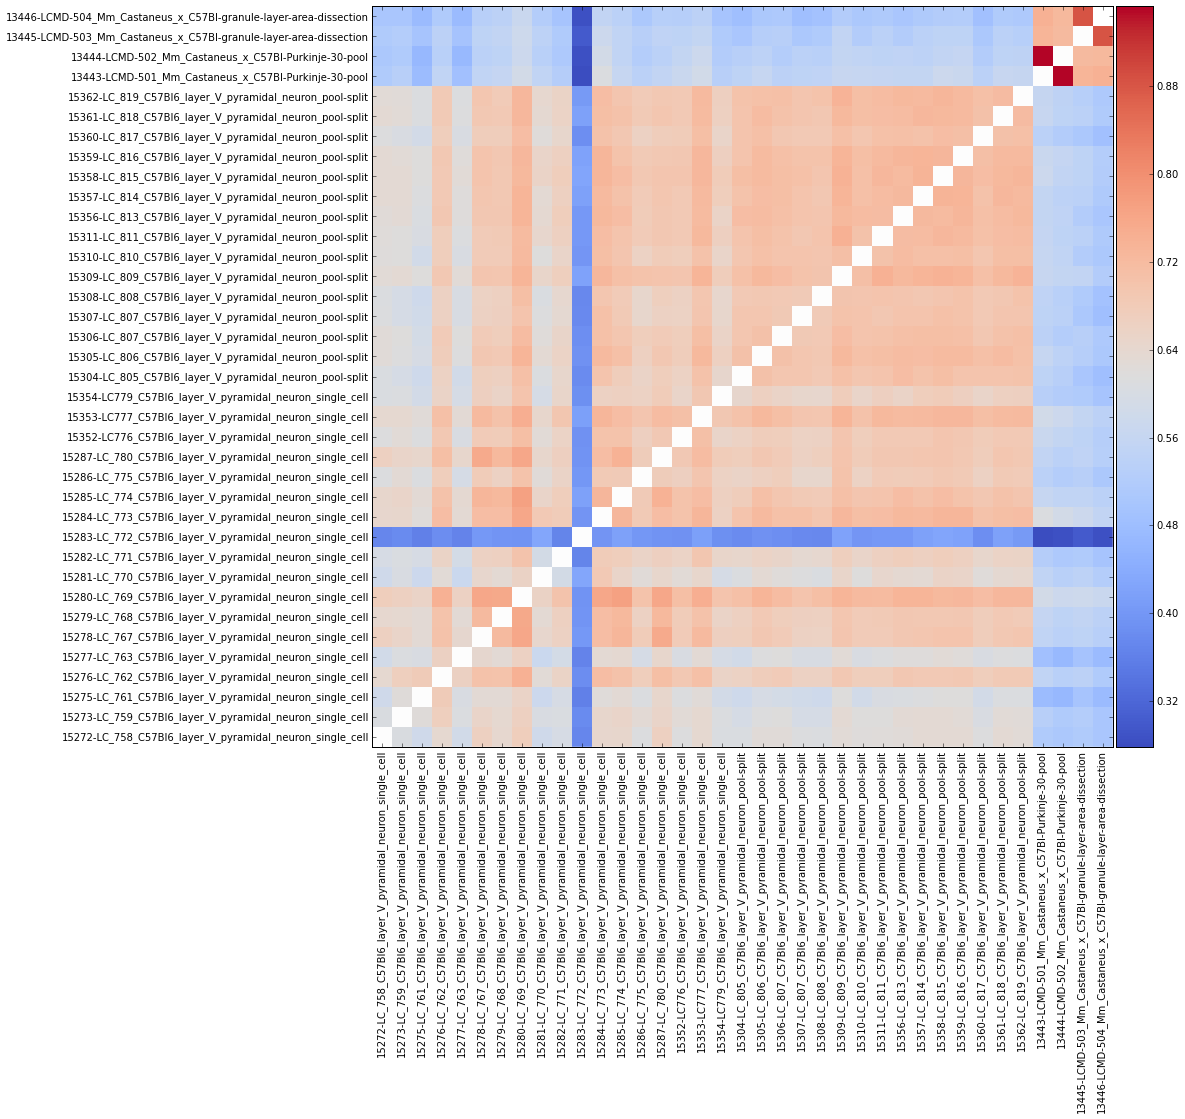

In [35]:
fig, ax = pyplot.subplots(1,1, figsize=(14,14))
heatmap(ax, scores['Rafa Pearson'][(scores['Rafa Pearson'] < 1.0)])

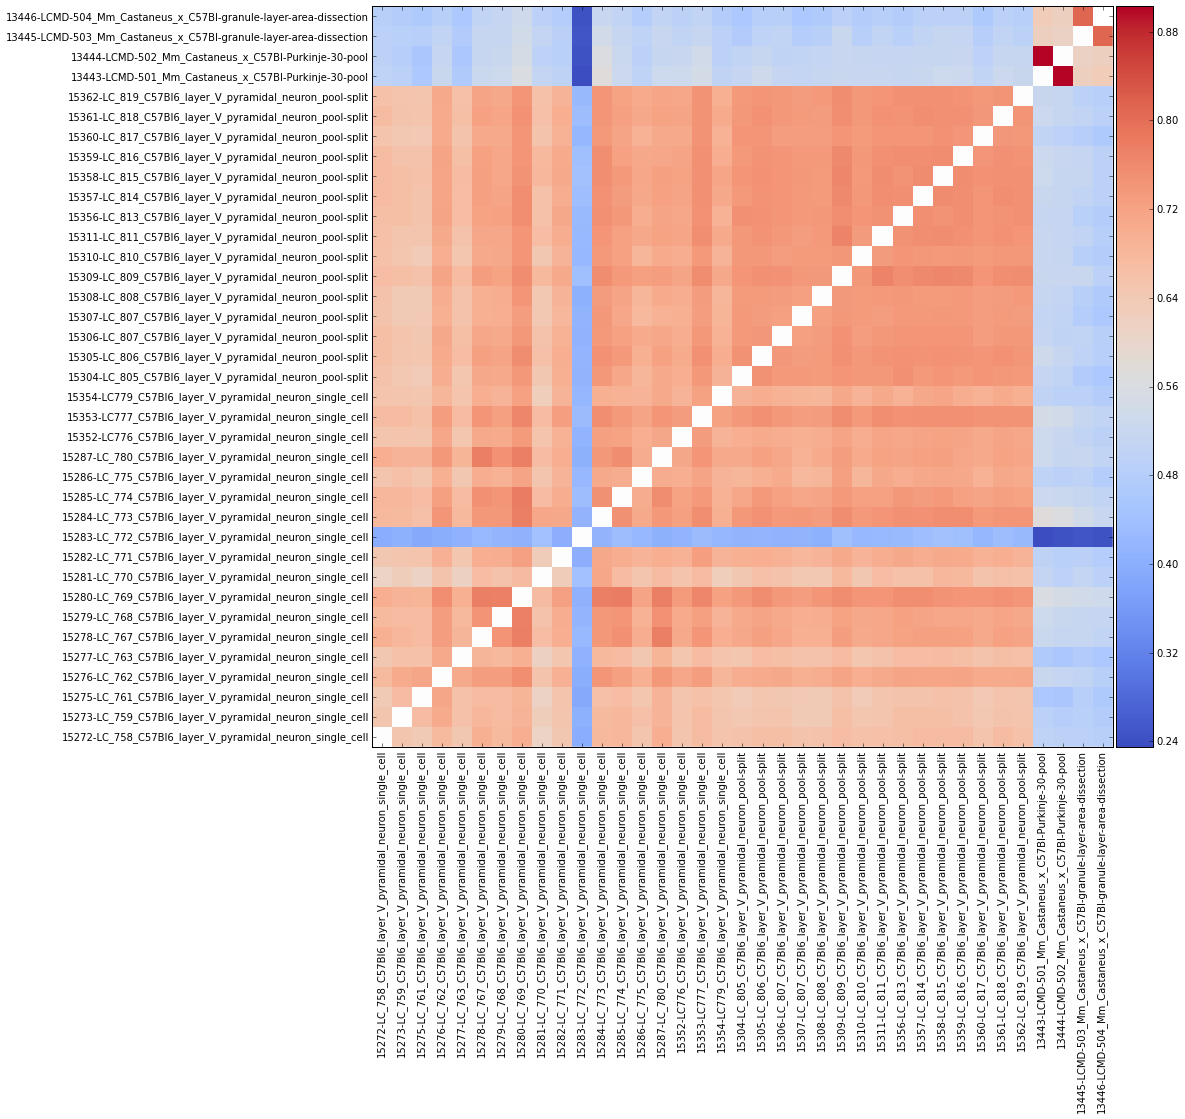

In [36]:
fig, ax = pyplot.subplots(1,1, figsize=(14,14))
heatmap(ax, scores['Rafa Spearman'][(scores['Rafa Spearman'] < 1.0)])

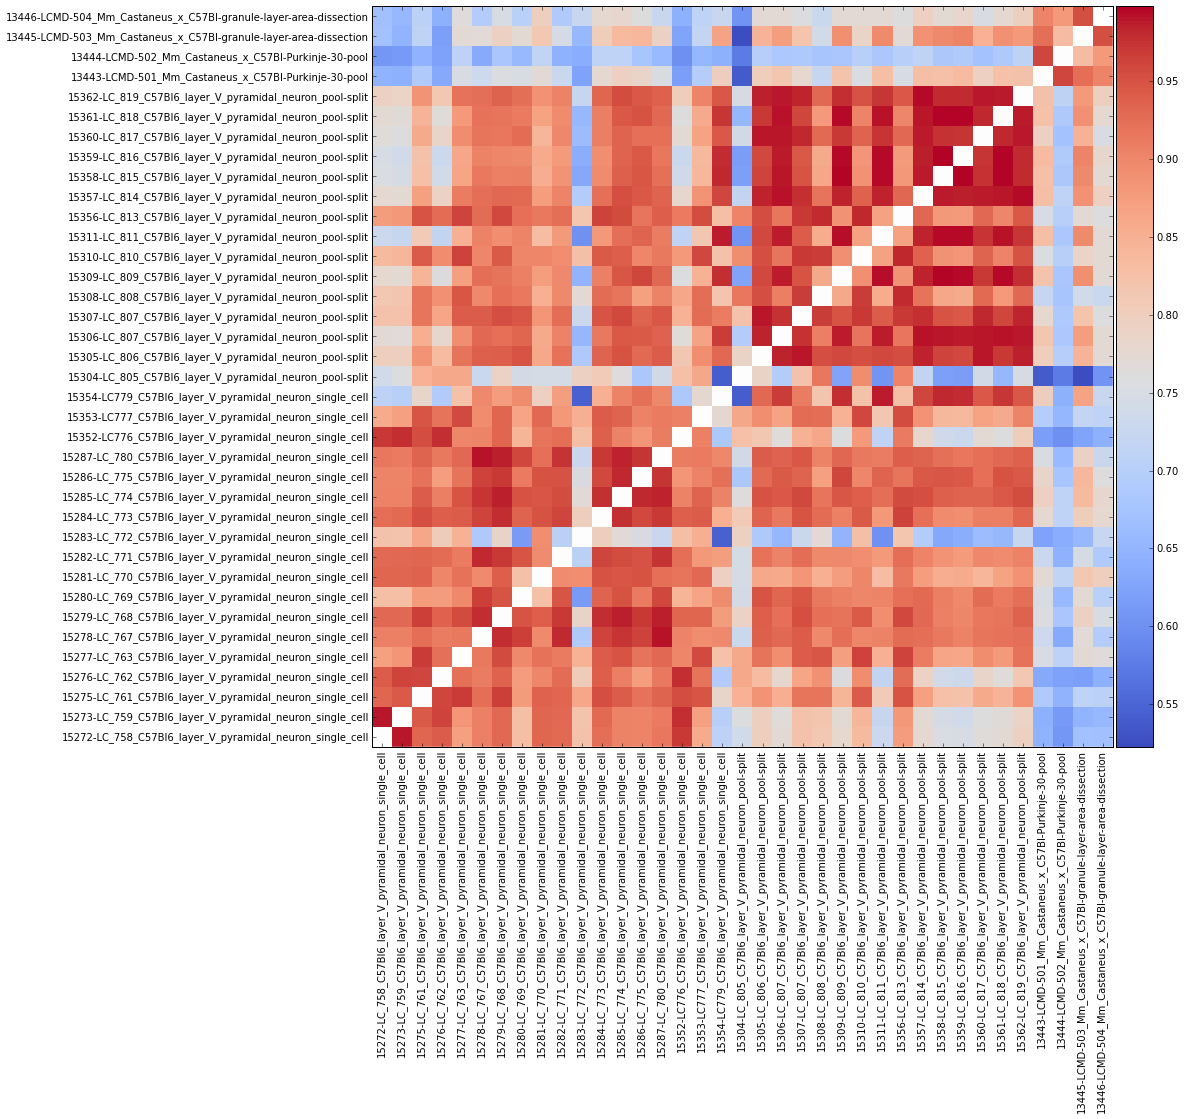

In [37]:
fig, ax = pyplot.subplots(1,1, figsize=(14,14))
heatmap(ax, scores['Naïve Pearson'][(scores['Naïve Pearson'] < 1.0)])

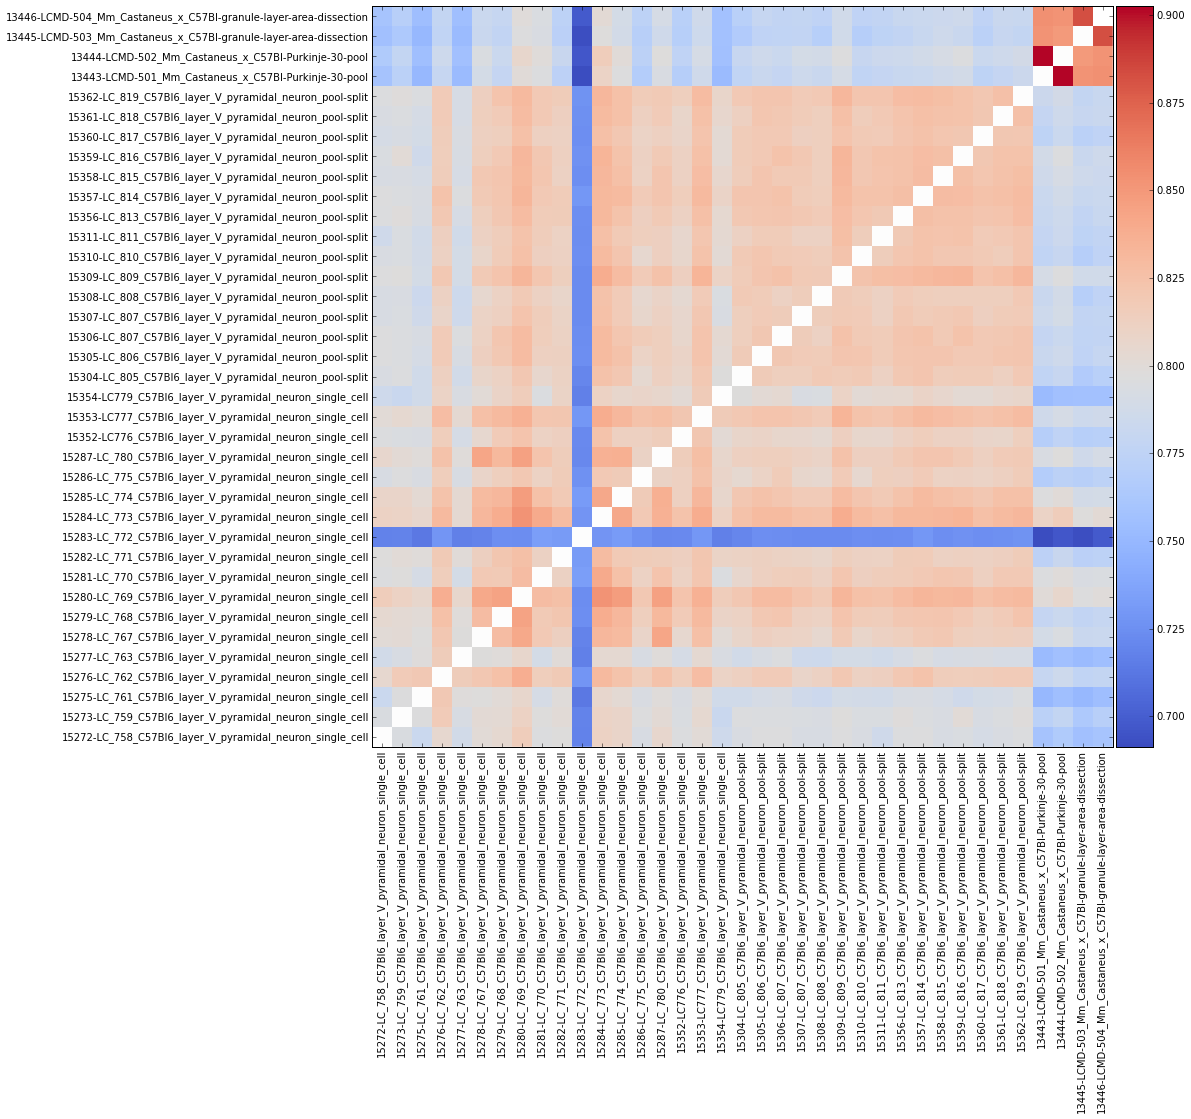

In [38]:
fig, ax = pyplot.subplots(1,1, figsize=(14,14))
heatmap(ax, scores['Naïve Spearman'][(scores['Naïve Spearman'] < 1.0)])

In [25]:
with pandas.ExcelWriter('/tmp/y3q3-scores.xlsx') as w:
    for name in scores.keys():
        scores[name].to_excel(w, sheet_name=name)
w.close()

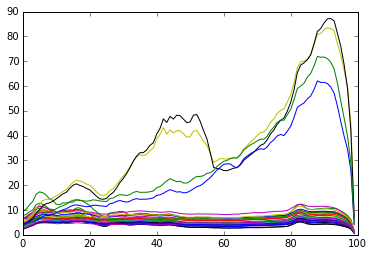

In [39]:
for name in summaries['coverage'].columns:
    pyplot.plot(summaries['coverage'][name])

(0, 20)

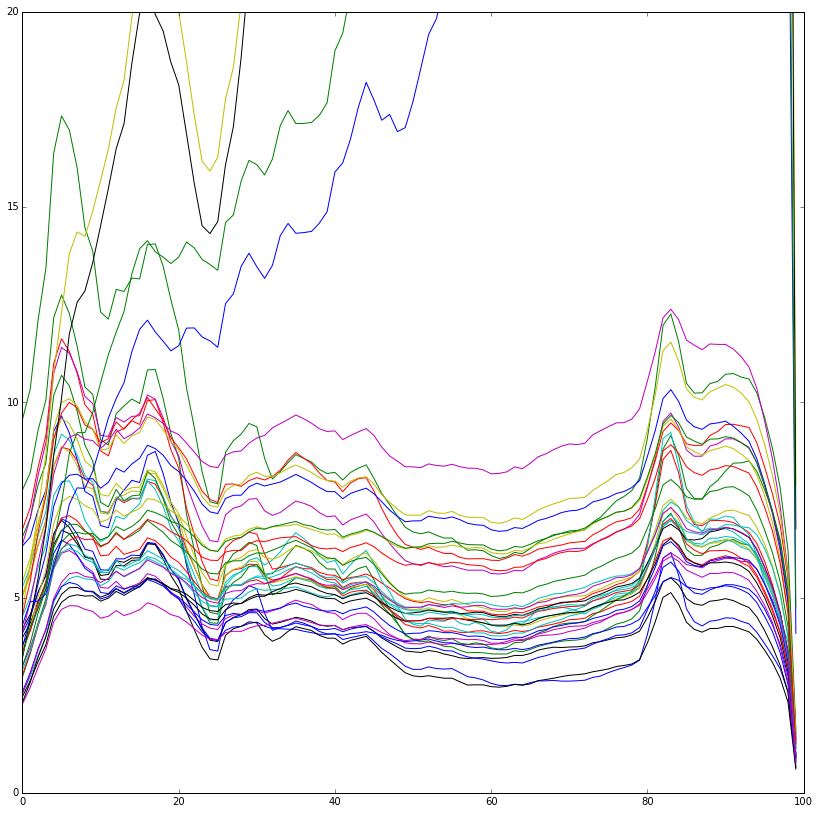

In [29]:
fig, ax = pyplot.subplots(1,1, figsize=(14,14))
ax.plot(summaries['coverage'])
ax.set_ylim(0,20)